# Offer Affinity Prediction Models

## Introduction

In this notebook we aim to develop a machine learning model to predict how likely a customer is to purchase a product should they be offered it. The user can specify one or multiple products which they would like to build models for. These models allow the user to identify which products the customer is most likely to consider next and what product should be offered to them. <br>

We make two assumptions before building our models:

    •	A customer could only purchase the product if they were offered it. We use this assumption when building our target variable. 
    •	The customers who were offered the product were selected randomly, therefore not introducing any bias into our model.

The target variable for each product is binary and indicates whether a customer purchased the product after being offered it or not. The notebook allows the user to load in the raw data, transform it into a format for modeling, build multiple models, save and deploy them.


**Sample Materials, provided under license. <br>
Licensed Materials - Property of IBM. <br>
© Copyright IBM Corp. 2019, 2020. All Rights Reserved. <br>
US Government Users Restricted Rights - Use, duplication or disclosure restricted by GSA ADP Schedule Contract with IBM Corp. <br>**

## Load Offer Affinity Data

For this project we will be loading the csv file called **customer_product_history.csv**. The file is located in the `/project_data/data_asset/` directory.

The easiest way to load in data is to use the <b>Find and Add Data</b> icon in the upper right hand corner. Once selected you will see a sidebar come out with options to load from either Files or Connections.

If you loaded your dataset into a Watson Studio analytics project, like a CSV file, then select Files and you should be able to find your dataset name. From there you can click the <b>Insert to code</b> and select to either insert a pandas dataframe or a spark dataframe. Once you make the selection you'll see python code inserted into the notebook cell with either Pandas or PySpark code for reading in your data. Now you're ready to explore and manipulate your dataset.

In [1]:
import pandas as pd      
import numpy as np
import shutil
from sklearn import metrics
import itertools
import time 
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.linear_model import LogisticRegression 
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import GridSearchCV


from sklearn.preprocessing import StandardScaler

import sys
if '/project_data/data_asset' not in sys.path:
    sys.path.insert(0, '/project_data/data_asset')
    
from offer_affinity_prep import *

# project-lib library contains functions that simplify fetching files associated with the project.
from project_lib import Project
project = Project()

## Functions

The following cells contain functions which are used throughout the code. 

The below function scales numerical variables, which is required for penalised logistic regression.

In [2]:
def scale_vars(X_train_scale, X_test_scale):
    
    # Since data is already prepped and dummy variables created, we loop through each column,
    # find columns that have more values than just [0, 1] and standardise these features
    # we scale using training dataset and apply to same scaling at test time
    l_cols_to_standardise = []
    for col in X_train_scale.columns:
        temp_contents = list(X_train_scale[col].unique())
        temp_contents.sort()
        if temp_contents != [0, 1]:
            l_cols_to_standardise.append(col)

    scaler = None
    if len(l_cols_to_standardise) > 0:
        scale_features_train = X_train_scale[l_cols_to_standardise]
        scale_features_test = X_test_scale[l_cols_to_standardise]

        scaler = StandardScaler()
        scaler.fit(scale_features_train.values)

        scale_features_train = scaler.transform(scale_features_train.values)
        scale_features_test = scaler.transform(scale_features_test.values)

        X_train_scale[l_cols_to_standardise] = scale_features_train
        X_test_scale[l_cols_to_standardise] = scale_features_test
    
    return X_train_scale, X_test_scale, scaler, l_cols_to_standardise

This next function takes an input of a dictionary of sklearn models, a dictionary of parameters for each model and flags allowing the user to specify if cross validation should be used and whether we want to print all results out or just the best performing hyperparameter selection for each model. It returns a dictionary with the best performing parameters and score for each model type.

In [3]:
def tune_models(models_dict, params_dict, X_train, X_test, y_train, y_test, use_cross_val=False, verbose=False):
   
    top_performing_results = {}

    for model_name, model in models_dict.items():
        print('    Building ' + model_name + ' models:')
        
        # We scale the variables if building a logistic regression model. This is necessary if the regression is regularised.
        if str(type(model)).endswith("sklearn.linear_model.logistic.LogisticRegression'>"):
            print('        Scaling variables for logistic regression')
            X_train_scale = X_train.copy() 
            X_test_scale = X_test.copy()

            # call the function that figures out columns to standardise and returns the standardised dataframes
            X_train_scale, X_test_scale, _, _ = scale_vars(X_train_scale, X_test_scale)

        top_performing_results[model_name] = {}

        if use_cross_val:
            
            cross_validation = StratifiedKFold(n_splits=5, random_state=0, shuffle=True)
            
            clf = GridSearchCV(model, params_dict[model_name], cv=cross_validation, scoring='roc_auc', return_train_score=True, iid=False)
            if str(type(model)).endswith("sklearn.linear_model.logistic.LogisticRegression'>"):
                clf.fit(X_train_scale, y_train)
            else:
                clf.fit(X_train, y_train)

            if verbose:
                print('\n        Printing out results for each parameter combination... \n')
                i = 0
                for param_score in clf.cv_results_['mean_test_score']:
                    print('        ' + str(clf.cv_results_['params'][i]) + ' - Cross Validated AUC: ' + str(np.round(param_score, 4)))
                    i = i + 1

            if str(type(model)).endswith("sklearn.linear_model.logistic.LogisticRegression'>"):
                y_pred_test = clf.predict_proba(X_test_scale)[:,1]
                y_pred_test_class = clf.predict(X_test_scale)
            else:
                y_pred_test = clf.predict_proba(X_test)[:,1]
                y_pred_test_class = clf.predict(X_test)
            
            fpr_test, tpr_test, thresholds_test = metrics.roc_curve(y_test, y_pred_test)
            auc_test = metrics.auc(fpr_test, tpr_test)
            
            confusion_matrix = metrics.confusion_matrix(y_test, y_pred_test_class, labels=[0,1])
            
            print('\n        ' + str(clf.best_params_) + ' - Best Cross Validated AUC: ' + str(np.round(clf.best_score_, 4)) + ' Test AUC: ' + str(np.round(auc_test, 4)) + '\n')

            # store the model results so we can select best model type
            top_performing_results[model_name]['model'] = clf.best_estimator_
            top_performing_results[model_name]['parameters'] = clf.best_params_
            top_performing_results[model_name]['score'] = auc_test
            top_performing_results[model_name]['fpr_test'] = fpr_test
            top_performing_results[model_name]['tpr_test'] = tpr_test
            top_performing_results[model_name]['confusion_matrix'] = confusion_matrix
            
        else:
            best_score = 0.0
            best_params = {}
            clf = model

            if verbose:
                print('\n        Printing out results for each parameter combination... \n')

            for param_combo in ParameterGrid(params_dict[model_name]):
                clf.set_params(**param_combo)
                
                if str(type(model)).endswith("sklearn.linear_model.logistic.LogisticRegression'>"):
                    clf.fit(X_train_scale, y_train)     
                    
                    y_pred_test = clf.predict_proba(X_test_scale)[:,1]
                    y_pred_train = clf.predict_proba(X_train_scale)[:,1]
                else:
                    clf.fit(X_train, y_train)     
                    
                    y_pred_test = clf.predict_proba(X_test)[:,1]
                    y_pred_train = clf.predict_proba(X_train)[:,1]
                    
                fpr_test, tpr_test, thresholds_test = metrics.roc_curve(y_test, y_pred_test)
                fpr_train, tpr_train, thresholds_train = metrics.roc_curve(y_train, y_pred_train)
                
                auc_test = metrics.auc(fpr_test, tpr_test)
                auc_train = metrics.auc(fpr_train, tpr_train)

                
                if verbose:    
                    if auc_test > best_score:
                        print('        ' + str(param_combo) + ' - Training AUC: ' + str(np.round(auc_train, 4)) + ' Test AUC: ' + str(np.round(auc_test, 4)) + '***')
                    else:
                        print('        ' + str(param_combo) + ' - Training AUC: ' + str(np.round(auc_train, 4)) + ' Test AUC: ' + str(np.round(auc_test, 4)))

                if auc_test > best_score:
                    best_score = auc_test
                    corresponding_train_score = auc_train
                    best_params = param_combo
      
             

            print('\n        Best test score - ' + str(best_params) + ' - Training AUC: ' + str(np.round(corresponding_train_score, 4)) + ' Test AUC: ' + str(np.round(best_score, 4)) + '\n')       

            # re-run the top performing model
            clf.set_params(**best_params)

            if str(type(model)).endswith("sklearn.linear_model.logistic.LogisticRegression'>"):
                clf.fit(X_train_scale, y_train)     

                y_pred_test = clf.predict_proba(X_test_scale)[:,1]
                y_pred_test_class = clf.predict(X_test_scale)
            else:
                clf.fit(X_train, y_train)     

                y_pred_test = clf.predict_proba(X_test)[:,1]
                y_pred_test_class = clf.predict(X_test)

            fpr_test, tpr_test, thresholds_test = metrics.roc_curve(y_test, y_pred_test)

            auc_test = metrics.auc(fpr_test, tpr_test)
            confusion_matrix = metrics.confusion_matrix(y_test, y_pred_test_class, labels=[0,1])
            
            # the model that is saved out here doesn't maintain the fitted status, model will need to be fitted again before saving out at end 
            top_performing_results[model_name]['model'] = clf 
            top_performing_results[model_name]['parameters'] = best_params
            top_performing_results[model_name]['score'] = best_score
            top_performing_results[model_name]['fpr_test'] = fpr_test
            top_performing_results[model_name]['tpr_test'] = tpr_test
            top_performing_results[model_name]['confusion_matrix'] = confusion_matrix

        
    return top_performing_results

The next two functions are used to create the confusion matrices and feature importance plots.

In [4]:
%matplotlib inline

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    Function to plot the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=14)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('Actual Label')
    plt.xlabel('Predicted Label')
    #plt.tight_layout()

In [5]:
def plot_feature_importance(feature_list, feature_importances, title='Feature Importance Plot'):
    """
    Function to Plot Feature Importances
    """
    features = feature_list
    importances = feature_importances
    indices = np.argsort(importances)[-10:]
    
    plt.figure(figsize=(12,7))
    plt.title(title, fontsize=17)
    plt.barh(range(len(indices)), importances[indices], color='b', align='center')
    plt.yticks(range(len(indices)), [features[i] for i in indices])
    plt.xlabel('Relative Importance')

## Data Prep and User Inputs


### User Inputs
**product_id :**  List with all products which we would like to prep and build models for.<br>

**train_or_score :**  Specify whether we are prepping the data for training or scoring. Should always be 'train' in this notebook.<br>

**customer_id_col :** Specifies the customer ID column.<br>
**customer_effective_date_col :** Specifies the effective date column.<br>
**customer_relationship_start_date_col :** Column with the customer acquisition date.<br>
**customer_summary_end_date :** Column with last day of month of customer's summary data. A customer has a record for each month of summary data.<br>
**customer_product_summary_end_date_col :** Column with last day of the month that a customer received a product offer.<br>

**required_product_attributes :** List used to dynamically create the columns which indicate whether a customer was offered the product and if they subsequently purchased it or not. Dynamically combines the elements in this list with products in product_id list to identify the columns in the raw dataset. Example included in code comments in the cell below.<br> 
**default_attributes :** A list of the variables that we would like to prep and use for modelling. The user can change or add their own variables to the list.<br>

**nulls_threshold :** This threshold is used to identify columns with many null values. Any column with percentage of nulls greater than this threshold will be removed from the dataset.<br>
**max_num_cat_cardinality :** This variable defines the maximum cardinality for categorical variables. Any categorical variable with more categories than this maximum is removed from the dataset.<br> 

**effective_date_earliest :**  The start point for model training. Any data from before this date is removed during the prep.<br>
**effective_date_latest :**  The last date for model training. Any data after this date is removed from the dataset when training.<br>

### Data Prep and Cleaning

See `project_data/data_asset/offer_affinity_prep.py` for data preparation code.

The script generates the dataset that is used for modelling. We use a wide form dataset with customer details, customer summary over time and details of any products which the customer purchased as input. 

As described in the Introduction, we have two assumptions, a customer could only purchase the product if they were offered it and the customers who were offered the product were selected randomly. With these two assumptions in place, we filter the data to include only customers who were offered the product based on a dynamic variable created from 'required_product_attributes' list. The target variable is also created from this list. If a customer purchased the product they get a target value of 1, otherwise it's 0. We also only take the latest date that the customer was offered the product, resulting in one record per customer.

#### Data Cleaning
 
The following cleaning steps are carried out:

•	Filter out any customer effective dates that are before or after the earliest and latest effective dates specified by the user.<br>
•	Any columns in the dataset that have a single constant value are removed.<br>
•	Any column with more than 'nulls_threshold' null values is removed.<br>
•	High cardinality categorical columns are removed, based on 'max_num_cat_cardinality' input variable.<br>
•	Remaining missing values are filled with 'Unknown' for categorical and the average of the column for numerical.<br>
•	Dummy variables are created for categorical variables.<br>
•	Date type columns are removed.<br>

We create an instance of a class and call the function to prep the data. The output is a dictionary with a key for each product and values consisting of the prepped dataframe for that product. The dataframe is made up of a mix of numerical data and binary dummy variables.

In [6]:
product_ids = ['EDUCATION', 'CASH', 'BROKERAGE', 'FINANCIALPLAN', 'RETIREMENTPLAN']

train_or_score = 'train'

customer_id_col = 'CUSTOMER_CUSTOMER_ID'
customer_effective_date_col = 'CUSTOMER_EFFECTIVE_DATE'
customer_relationship_start_date_col = 'CUSTOMER_RELATIONSHIP_START_DATE'
customer_summary_end_date = 'CUSTOMER_SUMMARY_END_DATE'
customer_product_summary_end_date_col = 'CUSTOMER_PRODUCT_SUMMARY_END_DATE'

# the column names indicating whether the customer was offered and purchased a product are dynamically created
# using the below list and the product_ids we are building models for
# column name in the dataset will have format of 'PID_' + product_id + '_CUSTOMER_PRODUCT_SUMMARY_' + 'PRODUCT_OFFERED_INDICATOR'/'PRODUCT_OWNED_INDICATOR'
# for example, PID_EDUCATION_CUSTOMER_PRODUCT_SUMMARY_PRODUCT_OFFERED_INDICATOR
required_product_attributes = ['PRODUCT_OFFERED_INDICATOR','PRODUCT_OWNED_INDICATOR']

default_attributes = [
                'CUSTOMER_AGE_RANGE',
                'CUSTOMER_EDUCATION_LEVEL',
                'CUSTOMER_GENDER',
                'CUSTOMER_URBAN_CODE',
                'CUSTOMER_MARKET_GROUP',
                'CUSTOMER_EMPLOYMENT_STATUS',
                'CUSTOMER_NUMBER_OF_DEPENDENT_ADULTS',
                'CUSTOMER_NUMBER_OF_DEPENDENT_CHILDREN',
                'CUSTOMER_MARITAL_STATUS',
                'CUSTOMER_SUMMARY_ASSETS',
                'CUSTOMER_SUMMARY_TOTAL_AMOUNT_OF_DEPOSITS',
                'CUSTOMER_ANNUAL_INCOME',
                'CUSTOMER_SUMMARY_NUMBER_OF_ACCOUNTS',
                'CUSTOMER_SUMMARY_TOTAL_AMOUNT_OF_ALL_FEES',
                'CUSTOMER_RELATIONSHIP_START_DATE',
                'CUSTOMER_INTERNET_BANKING_INDICATOR',
                'CUSTOMER_FAMILY_SIZE'
            ]

nulls_threshold = 0.1
max_num_cat_cardinality = 10
effective_date_earliest = '2016-01-01'
effective_date_latest = '2018-09-30'

In [7]:
customerProductHistory_file = project.get_file("customerProductHistory.csv")
customerProductHistory_file.seek(0)
df_raw = pd.read_csv(customerProductHistory_file, infer_datetime_format=True, parse_dates=[customer_effective_date_col, customer_relationship_start_date_col, customer_summary_end_date])

In [8]:
offer_affinity_prep = OfferAffinityPrep(train_or_score=train_or_score, product_id=product_ids, effective_date_earliest=effective_date_earliest,
                 effective_date_latest=effective_date_latest, nulls_threshold=nulls_threshold,
                 max_num_cat_cardinality=max_num_cat_cardinality, customer_id_col=customer_id_col,
                 customer_effective_date_col=customer_effective_date_col, customer_relationship_start_date_col=customer_relationship_start_date_col,
                 customer_summary_end_date=customer_summary_end_date, customer_product_summary_end_date_col=customer_product_summary_end_date_col,
                 required_product_attributes=required_product_attributes, default_attributes=default_attributes)

prepped_data = offer_affinity_prep.prep_data(df_raw, 'train')

2 columns were passed but are not contained in the data. :['CUSTOMER_SUMMARY_ASSETS', 'CUSTOMER_SUMMARY_TOTAL_AMOUNT_OF_ALL_FEES']
Prepping for EDUCATION
Before cleaning, we had 28 columns.
After cleaning, we have 27 columns.
Adding a column for customer tenure
Creating dummies for categorical variables
Final dataset shape: (312, 35)
Prepping for CASH
Before cleaning, we had 28 columns.
After cleaning, we have 27 columns.
Adding a column for customer tenure
Creating dummies for categorical variables
Final dataset shape: (353, 35)
Prepping for BROKERAGE
Before cleaning, we had 28 columns.
After cleaning, we have 27 columns.
Adding a column for customer tenure
Creating dummies for categorical variables
Final dataset shape: (359, 35)
Prepping for FINANCIALPLAN
Before cleaning, we had 28 columns.
After cleaning, we have 27 columns.
Adding a column for customer tenure
Creating dummies for categorical variables
Final dataset shape: (524, 35)
Prepping for RETIREMENTPLAN
Before cleaning, we ha

### Display Prepared Data

In [9]:
#Displaying prepared Data
for product_id in product_ids:
    print(product_id)
    display(prepped_data[product_id].head())
    print("{} rows, {} columns\n".format(*prepped_data[product_id].shape))

EDUCATION


,CUSTOMER_ANNUAL_INCOME,CUSTOMER_SUMMARY_NUMBER_OF_ACCOUNTS,CUSTOMER_NUMBER_OF_DEPENDENT_CHILDREN,CUSTOMER_FAMILY_SIZE,CUSTOMER_SUMMARY_TOTAL_AMOUNT_OF_DEPOSITS,Target,CUSTOMER_INTERNET_BANKING_INDICATOR,CUSTOMER_TENURE_IN_MONTHS,CUSTOMER_GENDER_Female,CUSTOMER_GENDER_Male,...,CUSTOMER_AGE_RANGE_65 and over,CUSTOMER_MARKET_GROUP_Accumulating,CUSTOMER_MARKET_GROUP_Gifting,CUSTOMER_MARKET_GROUP_Spending,CUSTOMER_MARKET_GROUP_Starting,CUSTOMER_EDUCATION_LEVEL_College,CUSTOMER_EDUCATION_LEVEL_High School,CUSTOMER_EDUCATION_LEVEL_PhD,CUSTOMER_EDUCATION_LEVEL_Professional,CUSTOMER_EDUCATION_LEVEL_University
1,280000.0,4,0,1,2363.747758,1,0,10,1,0,...,1,0,1,0,0,0,0,0,1,0
3,120000.0,3,0,2,949.947012,1,0,8,1,0,...,1,1,0,0,0,0,0,1,0,0
12,95000.0,2,0,1,707.496018,0,0,29,1,0,...,1,1,0,0,0,0,0,1,0,0
18,75000.0,2,2,4,427.219321,0,1,11,1,0,...,0,1,0,0,0,0,0,1,0,0
20,110000.0,3,2,4,1549.229516,1,1,0,0,1,...,0,1,0,0,0,0,0,0,0,1


312 rows, 35 columns

CASH


,CUSTOMER_ANNUAL_INCOME,Target,CUSTOMER_SUMMARY_NUMBER_OF_ACCOUNTS,CUSTOMER_NUMBER_OF_DEPENDENT_CHILDREN,CUSTOMER_FAMILY_SIZE,CUSTOMER_SUMMARY_TOTAL_AMOUNT_OF_DEPOSITS,CUSTOMER_INTERNET_BANKING_INDICATOR,CUSTOMER_TENURE_IN_MONTHS,CUSTOMER_GENDER_Female,CUSTOMER_GENDER_Male,...,CUSTOMER_AGE_RANGE_65 and over,CUSTOMER_MARKET_GROUP_Accumulating,CUSTOMER_MARKET_GROUP_Gifting,CUSTOMER_MARKET_GROUP_Spending,CUSTOMER_MARKET_GROUP_Starting,CUSTOMER_EDUCATION_LEVEL_College,CUSTOMER_EDUCATION_LEVEL_High School,CUSTOMER_EDUCATION_LEVEL_PhD,CUSTOMER_EDUCATION_LEVEL_Professional,CUSTOMER_EDUCATION_LEVEL_University
0,325000.0,1,2,1,3,768.523528,1,8,0,1,...,0,1,0,0,0,1,0,0,0,0
3,120000.0,1,3,0,2,949.947012,0,8,1,0,...,1,1,0,0,0,0,0,1,0,0
16,120000.0,0,2,0,1,1007.011058,0,9,1,0,...,0,1,0,0,0,0,0,1,0,0
18,75000.0,0,2,2,4,427.219321,1,11,1,0,...,0,1,0,0,0,0,0,1,0,0
20,110000.0,1,3,2,4,1549.229516,1,0,0,1,...,0,1,0,0,0,0,0,0,0,1


353 rows, 35 columns

BROKERAGE


,Target,CUSTOMER_ANNUAL_INCOME,CUSTOMER_SUMMARY_NUMBER_OF_ACCOUNTS,CUSTOMER_NUMBER_OF_DEPENDENT_CHILDREN,CUSTOMER_FAMILY_SIZE,CUSTOMER_SUMMARY_TOTAL_AMOUNT_OF_DEPOSITS,CUSTOMER_INTERNET_BANKING_INDICATOR,CUSTOMER_TENURE_IN_MONTHS,CUSTOMER_GENDER_Female,CUSTOMER_GENDER_Male,...,CUSTOMER_AGE_RANGE_65 and over,CUSTOMER_MARKET_GROUP_Accumulating,CUSTOMER_MARKET_GROUP_Gifting,CUSTOMER_MARKET_GROUP_Spending,CUSTOMER_MARKET_GROUP_Starting,CUSTOMER_EDUCATION_LEVEL_College,CUSTOMER_EDUCATION_LEVEL_High School,CUSTOMER_EDUCATION_LEVEL_PhD,CUSTOMER_EDUCATION_LEVEL_Professional,CUSTOMER_EDUCATION_LEVEL_University
0,1,325000.0,2,1,3,768.523528,1,8,0,1,...,0,1,0,0,0,1,0,0,0,0
3,0,120000.0,3,0,2,949.947012,0,8,1,0,...,1,1,0,0,0,0,0,1,0,0
7,1,140000.0,4,2,4,1450.160630,1,21,1,0,...,0,0,0,1,0,0,0,0,0,1
16,0,120000.0,2,0,1,1007.011058,0,9,1,0,...,0,1,0,0,0,0,0,1,0,0
18,0,75000.0,2,2,4,427.219321,1,11,1,0,...,0,1,0,0,0,0,0,1,0,0


359 rows, 35 columns

FINANCIALPLAN


,Target,CUSTOMER_ANNUAL_INCOME,CUSTOMER_SUMMARY_NUMBER_OF_ACCOUNTS,CUSTOMER_NUMBER_OF_DEPENDENT_CHILDREN,CUSTOMER_FAMILY_SIZE,CUSTOMER_SUMMARY_TOTAL_AMOUNT_OF_DEPOSITS,CUSTOMER_INTERNET_BANKING_INDICATOR,CUSTOMER_TENURE_IN_MONTHS,CUSTOMER_GENDER_Female,CUSTOMER_GENDER_Male,...,CUSTOMER_AGE_RANGE_65 and over,CUSTOMER_MARKET_GROUP_Accumulating,CUSTOMER_MARKET_GROUP_Gifting,CUSTOMER_MARKET_GROUP_Spending,CUSTOMER_MARKET_GROUP_Starting,CUSTOMER_EDUCATION_LEVEL_College,CUSTOMER_EDUCATION_LEVEL_High School,CUSTOMER_EDUCATION_LEVEL_PhD,CUSTOMER_EDUCATION_LEVEL_Professional,CUSTOMER_EDUCATION_LEVEL_University
1,1,280000.0,4,0,1,2363.747758,0,10,1,0,...,1,0,1,0,0,0,0,0,1,0
2,1,130000.0,2,0,2,1085.035927,1,13,1,0,...,0,1,0,0,0,0,0,1,0,0
4,1,350000.0,2,2,4,786.559430,0,8,0,1,...,0,1,0,0,0,1,0,0,0,0
6,1,100000.0,3,0,1,1251.465804,0,13,1,0,...,0,1,0,0,0,0,0,1,0,0
7,1,140000.0,4,2,4,1450.160630,1,21,1,0,...,0,0,0,1,0,0,0,0,0,1


524 rows, 35 columns

RETIREMENTPLAN


,Target,CUSTOMER_ANNUAL_INCOME,CUSTOMER_SUMMARY_NUMBER_OF_ACCOUNTS,CUSTOMER_NUMBER_OF_DEPENDENT_CHILDREN,CUSTOMER_FAMILY_SIZE,CUSTOMER_SUMMARY_TOTAL_AMOUNT_OF_DEPOSITS,CUSTOMER_INTERNET_BANKING_INDICATOR,CUSTOMER_TENURE_IN_MONTHS,CUSTOMER_GENDER_Female,CUSTOMER_GENDER_Male,...,CUSTOMER_AGE_RANGE_65 and over,CUSTOMER_MARKET_GROUP_Accumulating,CUSTOMER_MARKET_GROUP_Gifting,CUSTOMER_MARKET_GROUP_Spending,CUSTOMER_MARKET_GROUP_Starting,CUSTOMER_EDUCATION_LEVEL_College,CUSTOMER_EDUCATION_LEVEL_High School,CUSTOMER_EDUCATION_LEVEL_PhD,CUSTOMER_EDUCATION_LEVEL_Professional,CUSTOMER_EDUCATION_LEVEL_University
1,0,280000.0,4,0,1,2363.747758,0,10,1,0,...,1,0,1,0,0,0,0,0,1,0
2,1,130000.0,2,0,2,1085.035927,1,13,1,0,...,0,1,0,0,0,0,0,1,0,0
4,1,350000.0,2,2,4,786.559430,0,8,0,1,...,0,1,0,0,0,1,0,0,0,0
6,1,100000.0,3,0,1,1251.465804,0,13,1,0,...,0,1,0,0,0,0,0,1,0,0
7,1,140000.0,4,2,4,1450.160630,1,21,1,0,...,0,0,0,1,0,0,0,0,0,1


534 rows, 35 columns



### Target Distribution for each Product

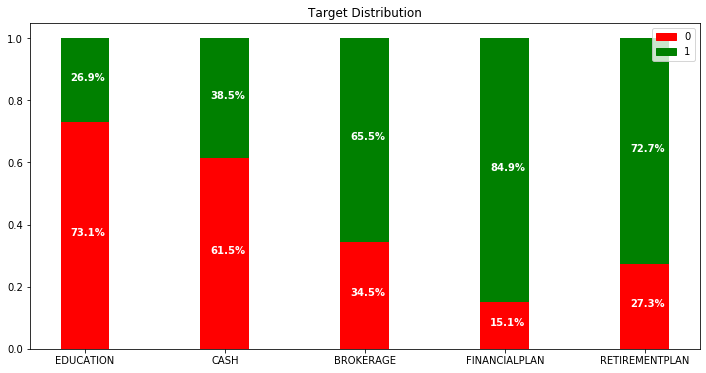

In [10]:
# plot the distribution of the target for each product
target_0 = []
target_1 = []

for product_id in product_ids:
    df_temp = prepped_data[product_id]['Target'].value_counts().reset_index()
    df_temp['perc'] = df_temp['Target'] / df_temp['Target'].sum()
    
    target_0.append(df_temp[df_temp['index']==0]['perc'].values[0])
    target_1.append(df_temp[df_temp['index']==1]['perc'].values[0])
    
fig1, ax1 = plt.subplots(figsize=(12,6))

ax1.bar(product_ids, target_0, 0.35, label=target_0, color='red')
ax1.bar(product_ids, target_1, 0.35, bottom=target_0, color='green')

red_patch = mpatches.Patch(color='green', label='1')
blue_patch = mpatches.Patch(color='red', label='0')

plt.legend(handles=[blue_patch, red_patch], loc='best')

plt.title('Target Distribution')

for p in ax1.patches:
        percentage = '{:.1f}%'.format(100 * p.get_height()/1)
        x = p.get_x() + p.get_width()/len(product_ids)
        y = p.get_y() + p.get_height()/2
        ax1.annotate(percentage, (x, y), color='white', weight='bold')
        
plt.show()

### Splitting the Data

The code below splits the data into training and testing datasets for each product and stores them in a nested dictionary.

We use 70% of the data for training and 30% for testing. The data is split in a stratified way, ensuring that the distribution of the target variable is similar in the training and test datasets.

In [11]:
split_data = {}

for product_id, training_data in prepped_data.items():
    
    X_inputs = training_data.drop(['Target'], axis=1)
    y_output = training_data['Target']
    
    X_train, X_test, y_train, y_test = train_test_split(X_inputs, y_output, stratify=y_output, test_size=0.30, random_state=42)
    
    split_data[product_id] = {
        'X_train': X_train, 'y_train': y_train,
        'X_test':  X_test,  'y_test':  y_test
    }

for product_id, splits in split_data.items():
    print("{} Train and Test Data Dimensions:".format(product_id))
    for split, df in splits.items():
        print("{} shape: {}".format(split, df.shape))
    print()

EDUCATION Train and Test Data Dimensions:
X_train shape: (218, 34)
y_train shape: (218,)
X_test shape: (94, 34)
y_test shape: (94,)

CASH Train and Test Data Dimensions:
X_train shape: (247, 34)
y_train shape: (247,)
X_test shape: (106, 34)
y_test shape: (106,)

BROKERAGE Train and Test Data Dimensions:
X_train shape: (251, 34)
y_train shape: (251,)
X_test shape: (108, 34)
y_test shape: (108,)

FINANCIALPLAN Train and Test Data Dimensions:
X_train shape: (366, 34)
y_train shape: (366,)
X_test shape: (158, 34)
y_test shape: (158,)

RETIREMENTPLAN Train and Test Data Dimensions:
X_train shape: (373, 34)
y_train shape: (373,)
X_test shape: (161, 34)
y_test shape: (161,)



## Building Machine Learning Models

The next step is to build the machine learning models. We'll build 3 models:

 1. Logistic Regression
 2. Random Forests
 3. Gradient Boosting for Classification
 
The user can change or add other models to the 'models_dict' if they would like to try out different model types.
 
For each model, we pass a number of hyperparameters into the `'params_dict'` and carry out model tuning using grid search. Again, these hyperparameters can be changed by the user or more can be added.
 
We also include two flags, `'use_cross_val'` and `'verbose'`. 
 
When 'use_cross_val' is True, we use 5 fold cross validation on the training set when tuning our models. We apply the models with best performing hyperparameter selection to the test set and return the cross validated training and test scores. This flag can be set to False if the user does not need to carry out cross validation. 

If 'verbose' is set to True, the code outputs the results of the models with every hyperparameter combination. If False, only the results and hyperparameter combination of the best performing of each model type is output. 

The 'tune_models' function builds the models and returns a dictionary with the tuned models. The dictionary contains a copy of the model for each model type, the hyperparameters that gave the best performing model, the AUC score, arrays with true and false positive rates, which will be used for plotting the ROC curve, and finally the confusion matrix data for each of the model types. 

In [12]:
# pass in the models that we would like to try out
models_dict = {
    'LogisticRegression': LogisticRegression(random_state=0),
    'RandomForestClassifier': RandomForestClassifier(random_state=0),
    'GradientBoostingClassifier': GradientBoostingClassifier(random_state=0)
}

# pass in the different hyperparameters that we want to try
# if we want to use default parameters leave the dictionary for each model empty
params_dict = {
    'LogisticRegression': {'penalty': ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1, 10], 'solver': ['liblinear']},
    'RandomForestClassifier': {'n_estimators': [50, 100, 150], 'max_depth' : [5, 10, 15], 'max_features' : [0.75, 0.9]},
    'GradientBoostingClassifier': {'learning_rate': [0.001, 0.01, 0.1], 'n_estimators': [10, 50, 100], 'max_depth' : [3, 5, 7]}
}

# flag to allow user to specify whether to use cross validation or not when doing hyperparameter tuning for each model 
# note that if cross validation is not used the model that is saved out needs to be refitted
use_cross_val = False
# True or False flag. If True, it prints out the AUC score for each hyperparameter combination and each model
# If False, prints out the hyperparameter combination giving the best AUC score for each mode
verbose = True

#store the results in a dictionary with a key for each product id

model_results_dict = {}

for product_id in split_data.keys():
    
    X_train = split_data[product_id]['X_train']
    y_train = split_data[product_id]['y_train']
    X_test = split_data[product_id]['X_test']
    y_test = split_data[product_id]['y_test']
    
    print('\n*************************    ' + product_id + ' Model Tuning   *************************\n')

    model_results_dict[product_id] = {}
    model_results_dict[product_id] = tune_models(models_dict, params_dict, X_train, X_test, y_train, y_test, use_cross_val, verbose)


*************************    EDUCATION Model Tuning   *************************

    Building LogisticRegression models:

        Printing out results for each parameter combination... 

        {'C': 0.001, 'penalty': 'l1', 'solver': 'liblinear'} - Training AUC: 0.5553 Test AUC: 0.5646***
        {'C': 0.001, 'penalty': 'l2', 'solver': 'liblinear'} - Training AUC: 0.5647 Test AUC: 0.5687***
        {'C': 0.01, 'penalty': 'l1', 'solver': 'liblinear'} - Training AUC: 0.5869 Test AUC: 0.6064***
        {'C': 0.01, 'penalty': 'l2', 'solver': 'liblinear'} - Training AUC: 0.5647 Test AUC: 0.5687
        {'C': 0.1, 'penalty': 'l1', 'solver': 'liblinear'} - Training AUC: 0.6544 Test AUC: 0.6806***
        {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'} - Training AUC: 0.5647 Test AUC: 0.5687
        {'C': 1, 'penalty': 'l1', 'solver': 'liblinear'} - Training AUC: 0.8993 Test AUC: 0.9136***
        {'C': 1, 'penalty': 'l2', 'solver': 'liblinear'} - Training AUC: 0.5647 Test AUC: 0.5687
   

        {'max_depth': 5, 'max_features': 0.9, 'n_estimators': 50} - Training AUC: 0.9703 Test AUC: 0.8315
        {'max_depth': 5, 'max_features': 0.9, 'n_estimators': 100} - Training AUC: 0.9704 Test AUC: 0.8349
        {'max_depth': 5, 'max_features': 0.9, 'n_estimators': 150} - Training AUC: 0.9697 Test AUC: 0.8375
        {'max_depth': 10, 'max_features': 0.75, 'n_estimators': 50} - Training AUC: 0.9992 Test AUC: 0.809
        {'max_depth': 10, 'max_features': 0.75, 'n_estimators': 100} - Training AUC: 0.9999 Test AUC: 0.8174
        {'max_depth': 10, 'max_features': 0.75, 'n_estimators': 150} - Training AUC: 1.0 Test AUC: 0.8201
        {'max_depth': 10, 'max_features': 0.9, 'n_estimators': 50} - Training AUC: 0.9998 Test AUC: 0.8066
        {'max_depth': 10, 'max_features': 0.9, 'n_estimators': 100} - Training AUC: 0.9999 Test AUC: 0.8227
        {'max_depth': 10, 'max_features': 0.9, 'n_estimators': 150} - Training AUC: 1.0 Test AUC: 0.8295
        {'max_depth': 15, 'max_feature

        {'learning_rate': 0.001, 'max_depth': 3, 'n_estimators': 10} - Training AUC: 0.7075 Test AUC: 0.6089***
        {'learning_rate': 0.001, 'max_depth': 3, 'n_estimators': 50} - Training AUC: 0.7297 Test AUC: 0.6106***
        {'learning_rate': 0.001, 'max_depth': 3, 'n_estimators': 100} - Training AUC: 0.7383 Test AUC: 0.618***
        {'learning_rate': 0.001, 'max_depth': 5, 'n_estimators': 10} - Training AUC: 0.8621 Test AUC: 0.5695
        {'learning_rate': 0.001, 'max_depth': 5, 'n_estimators': 50} - Training AUC: 0.8871 Test AUC: 0.6091
        {'learning_rate': 0.001, 'max_depth': 5, 'n_estimators': 100} - Training AUC: 0.8925 Test AUC: 0.5999
        {'learning_rate': 0.001, 'max_depth': 7, 'n_estimators': 10} - Training AUC: 0.9287 Test AUC: 0.5331
        {'learning_rate': 0.001, 'max_depth': 7, 'n_estimators': 50} - Training AUC: 0.9287 Test AUC: 0.5247
        {'learning_rate': 0.001, 'max_depth': 7, 'n_estimators': 100} - Training AUC: 0.9287 Test AUC: 0.5289
        

        {'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 100} - Training AUC: 0.9984 Test AUC: 0.7593
        {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 10} - Training AUC: 0.9046 Test AUC: 0.8588***
        {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50} - Training AUC: 0.9728 Test AUC: 0.8366
        {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100} - Training AUC: 0.9948 Test AUC: 0.8318
        {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 10} - Training AUC: 0.9713 Test AUC: 0.7603
        {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 50} - Training AUC: 1.0 Test AUC: 0.7463
        {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100} - Training AUC: 1.0 Test AUC: 0.7453
        {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 10} - Training AUC: 0.9981 Test AUC: 0.6634
        {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 50} - Training AUC: 1.0 Test AUC: 0.7587
        {'learning_rate': 0.1, 'max_dep

### View Model Results

Next we'll look at the results of the models. We plot the ROC curve for each model type and use the area under the ROC curve (AUC) as the model evaluation metric. The ROC curve is a plot of the true positive rate `(Sensitivity)` and false positive rate `(1-Specificity)`. Each point on the ROC curve represents a sensitivity/specificity pair corresponding to a particular decision threshold.

 The area under the ROC curve (AUC) is a measure of how well a parameter can distinguish between two groups.

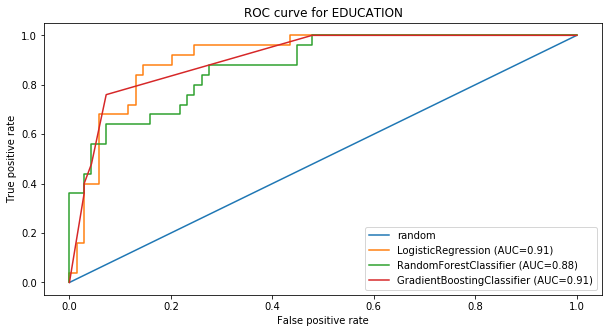

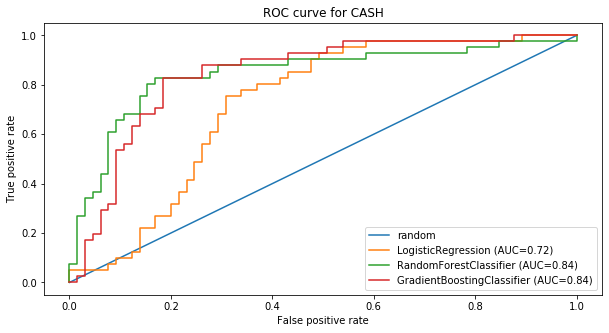

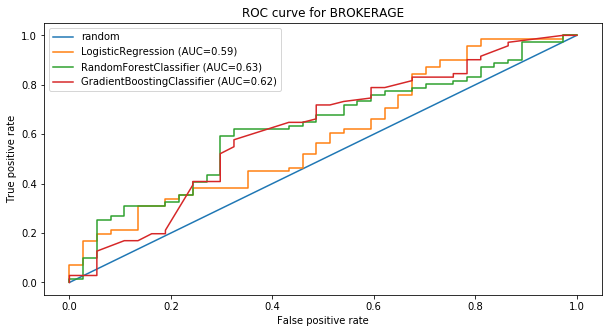

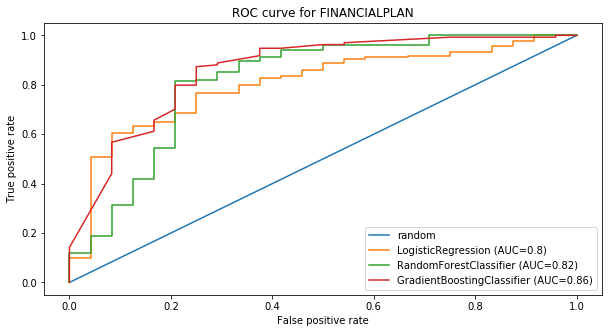

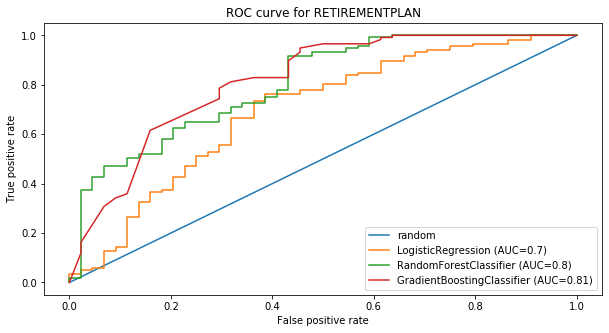

In [13]:
for product_id in model_results_dict.keys():
    
    fig = plt.figure(figsize=(10,5))

    plt.plot([0, 1], [0, 1], label='random')
    

    for model_type in model_results_dict[product_id].keys():            
            fpr_test = model_results_dict[product_id][model_type]['fpr_test']
            tpr_test = model_results_dict[product_id][model_type]['tpr_test']
            
            auc_test = metrics.auc(fpr_test, tpr_test)
            
            plt.plot(fpr_test, tpr_test, label=model_type + ' (AUC=' + str(np.round(auc_test, 2)) + ')')

            
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve for ' + product_id)
    plt.legend(loc='best')

plt.show()

In [14]:
# loop through the dictionary to pull out the scores for each model 
scores_dict = {}
for product_id in model_results_dict.keys():
    scores_dict[product_id] = {}
    for model in model_results_dict[product_id].keys():
        scores_dict[product_id][model] = np.round(model_results_dict[product_id][model]['score'], 3)
df_auc_score = pd.DataFrame(scores_dict)

print('AUC by Model:')
df_auc_score

AUC by Model:


,EDUCATION,CASH,BROKERAGE,FINANCIALPLAN,RETIREMENTPLAN
GradientBoostingClassifier,0.908,0.842,0.621,0.859,0.815
LogisticRegression,0.914,0.723,0.593,0.803,0.695
RandomForestClassifier,0.876,0.844,0.626,0.815,0.803


### Plot Confusion Matrices

We'll also look at the confusion matrix for each model type to summarise the performace of the models and see what types of errors are being made.

**`plot_confusion_matrix`**: This function plots an annotated and more presentable confusion matrix for the classification model results.

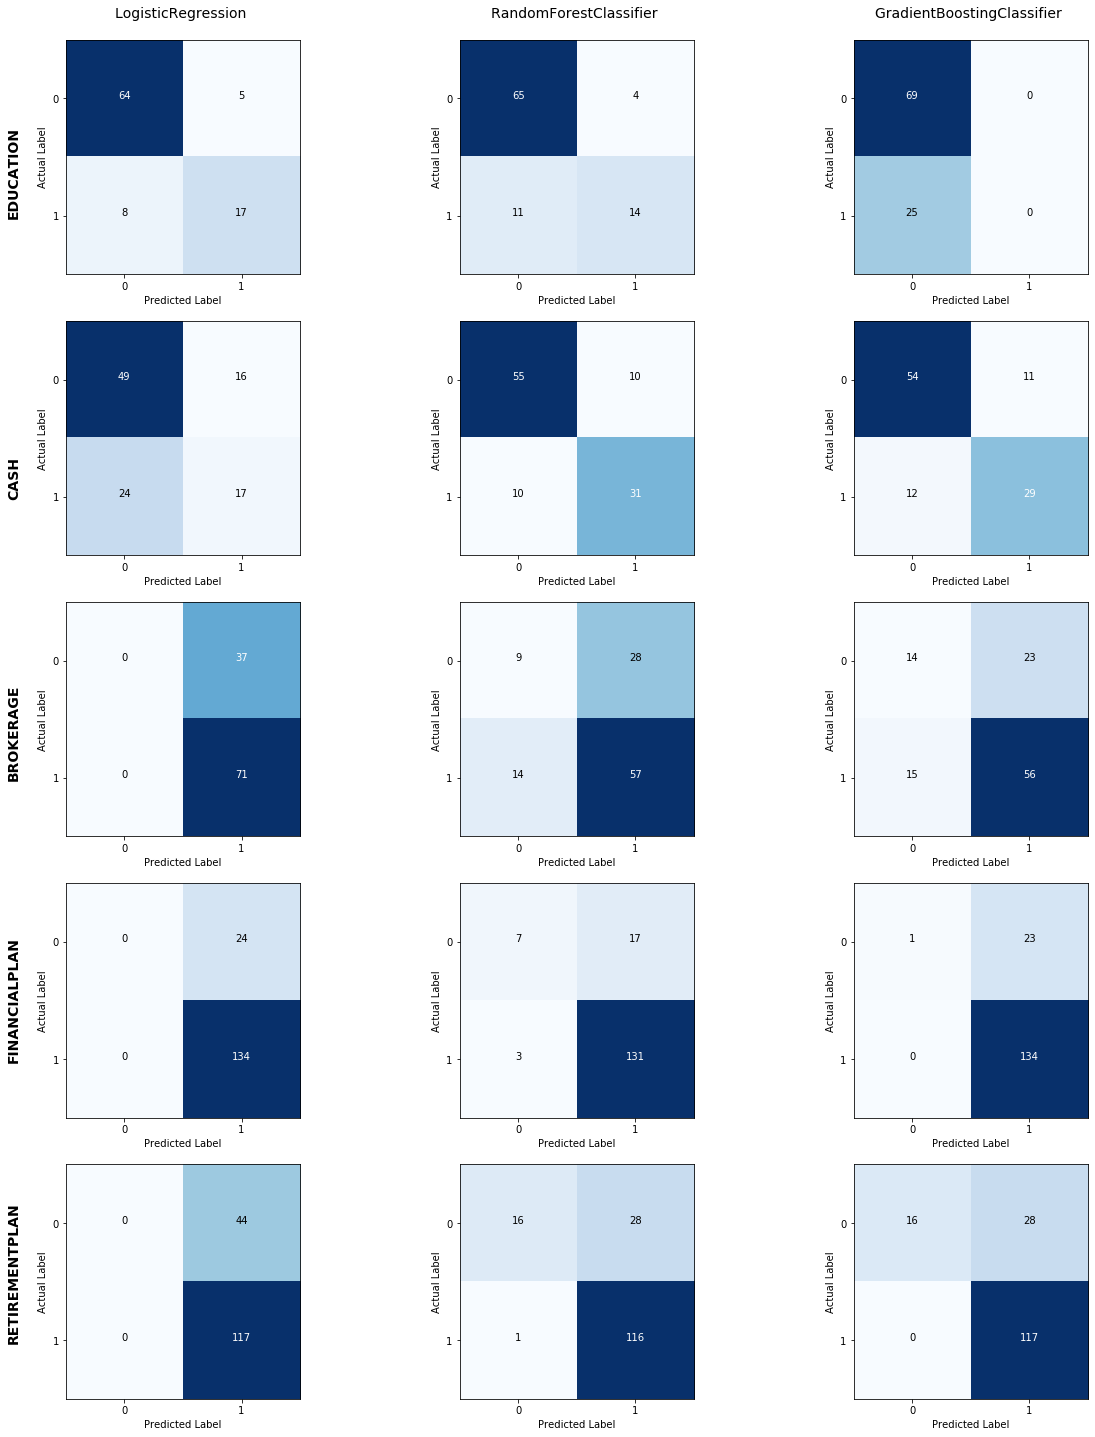

In [15]:
# Iterate over model types, calculating and then plotting confusion matrices

# dynamically change the figure size depending on the number of products the user has selected
fig = plt.figure(figsize=(20,(5 * len(product_ids))))
plot = 1

product_num = 0
for product_id in model_results_dict.keys():
    model_num = 0
    for model_type in model_results_dict[product_id].keys():
        confusion_matrix = model_results_dict[product_id][model_type]['confusion_matrix']

        fig.add_subplot(len(model_results_dict.keys()), len(models_dict.keys()), plot)
        
        if model_num == 0:
            
            plt.text(-1,1,product_id, rotation=90, fontsize=14, fontweight="bold")
        
        plot_confusion_matrix(confusion_matrix, normalize=False, classes=['0','1'], title=(model_type if product_num==0 else '')+' \n') 
        plot += 1
        
        model_num += 1
    product_num += 1

### Select Best Model For Each Product

Based on the AUC metric, select the best model for each product.

In [16]:
max_scores_per_product_dict = {}

for product_id in scores_dict.keys():
    max_scores_per_product_dict[product_id] = {}
    top_performing_model = max(scores_dict[product_id], key=scores_dict[product_id].get)
    max_scores_per_product_dict[product_id][top_performing_model] = scores_dict[product_id][top_performing_model]
    
df_max_score_per_product = pd.DataFrame.from_dict(max_scores_per_product_dict, orient='index').stack().reset_index()
df_max_score_per_product.columns = ['product_id', 'model_type', 'AUC']

df_max_score_per_product

,product_id,model_type,AUC
0,BROKERAGE,RandomForestClassifier,0.626
1,CASH,RandomForestClassifier,0.844
2,EDUCATION,LogisticRegression,0.914
3,FINANCIALPLAN,GradientBoostingClassifier,0.859
4,RETIREMENTPLAN,GradientBoostingClassifier,0.815


### Override Selected Models

If you would like to select a different class of model to be used, set the override dict with the product_id's mapping to the model types you would like to use for the respective event types. If happy with the top performing models leave the dictionary empty.

In [17]:
override_dict = {}

if len(override_dict) > 0:
    for product_id, model_type in override_dict.items():
        max_scores_per_product_dict[product_id] = {model_type: scores_dict[product_id][model_type]}

    df_max_score_per_product = pd.DataFrame.from_dict(max_scores_per_product_dict, orient='index').stack().reset_index()
    df_max_score_per_product.columns = ['product_id', 'model_type', 'AUC']

df_max_score_per_product

,product_id,model_type,AUC
0,BROKERAGE,RandomForestClassifier,0.626
1,CASH,RandomForestClassifier,0.844
2,EDUCATION,LogisticRegression,0.914
3,FINANCIALPLAN,GradientBoostingClassifier,0.859
4,RETIREMENTPLAN,GradientBoostingClassifier,0.815


### Plot Feature Importance

With some models you can view variable importance plots. These plots indicate, at the feature level, some importance for the variable to classify the outcome variable. It uses gini importance (mean decrease in impurity) which looks at node impurity. Node impurity is just looking at how well a tree splits the data. Technically it calculates each feature importance as the sum over the number of splits that include the feature, proportionally to the number of samples it splits.

We'll take a look at the feature importance plots for the best performing models. The top models in terms of accuracy were random forest and gradient boosting.

**`plot_feature_importance`**: This plots an annotated and more presentable variable importance plot for the top 10 variables.

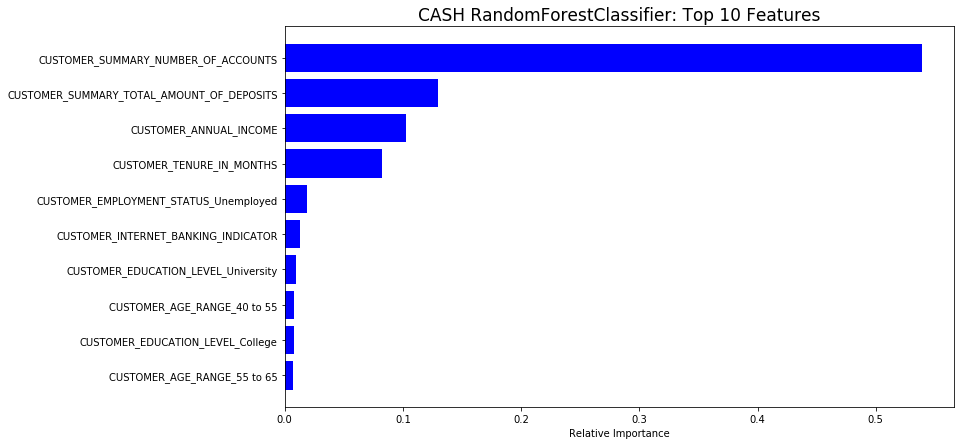

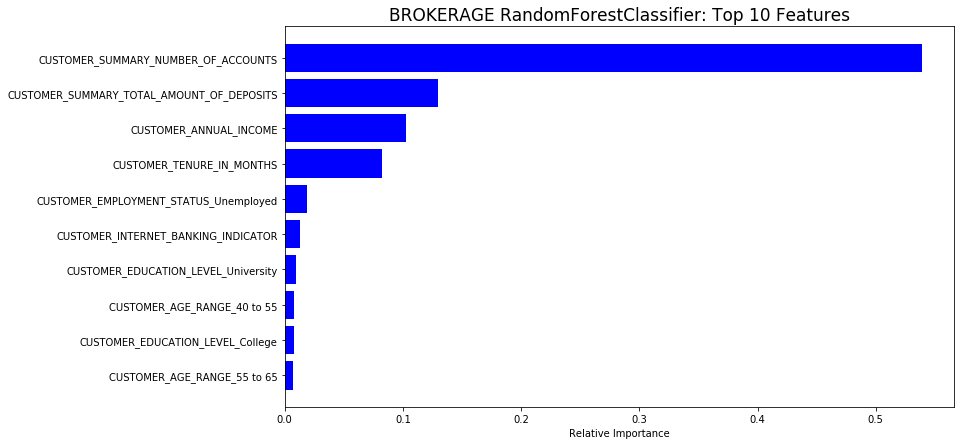

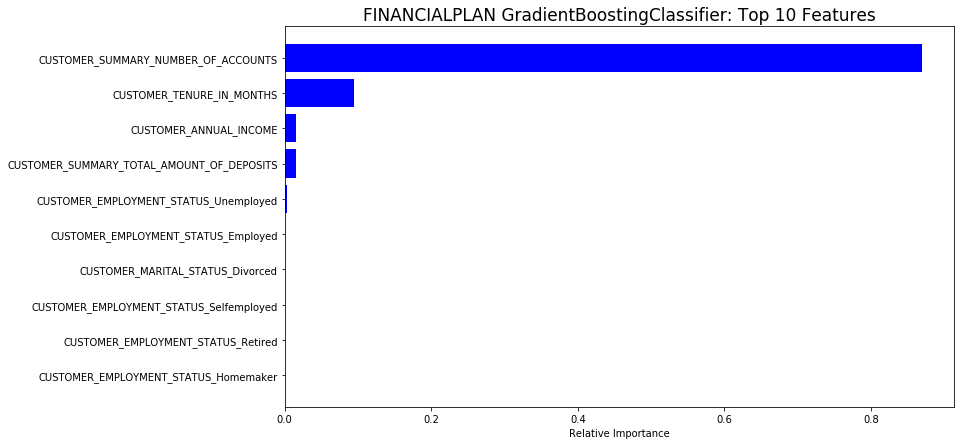

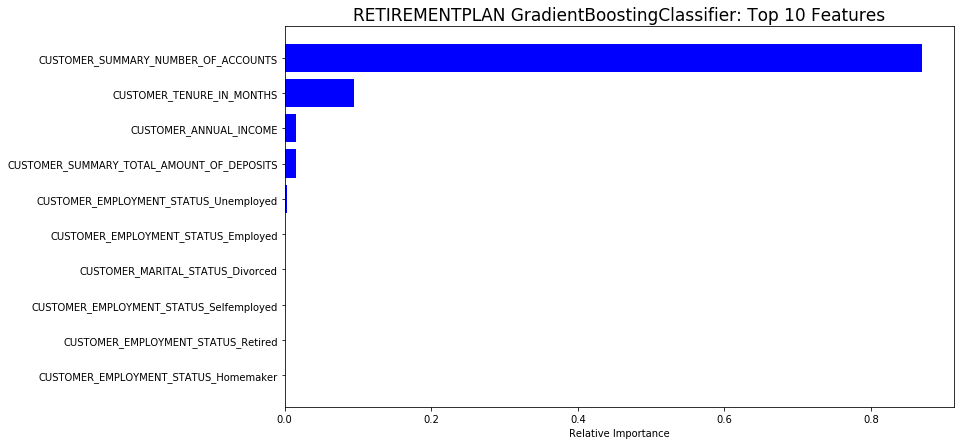

In [18]:
# Iterate over best models and show features importance if possible
for product_id in max_scores_per_product_dict.keys():
    for model_type in max_scores_per_product_dict[product_id].keys():
        if model_type != 'LogisticRegression':
            plot_feature_importance(feature_list=split_data[product_id]['X_train'].columns.tolist(),
                                        feature_importances=model_results_dict[product_id][model_type]['model'].feature_importances_,
                                        title="{} {}: Top 10 Features".format(product_id, model_type))

### Save the best classification model to Cloud Pak for Data

We select the top performing model for each product. In the next steps we save and deploy the models. 

Before we save the models we must create a deployment space. Watson Machine Learning provides deployment spaces where the user can save, configure and deploy their models. We can save models, functions and data assets in this space. 



The steps involved in saving and deploying the pipeline are detailed in the following cells. We will use the [ibm-watson-machine-learning](http://ibm-wml-api-pyclient.mybluemix.net) package to complete these steps.


### User Inputs
The user can specify the names for the space, models and model deployments.

If a space with specified space_name already exists, user can either use the existing space by specifying `use_existing_space=True` or delete the existing space and create a new one by specifying `use_existing_space=False` below. By default use_existing_space is set to `True`

In [19]:
# Specify a name for the space being created, the saved model and the model deployment
space_name = 'Customer Offer Affinity Space'
use_existing_space=True

In [20]:
model_names = {}
deployment_names = {}
for product_id in max_scores_per_product_dict.keys():
    model_names[product_id] = 'offer_affinity_' + product_id + '_model'
    deployment_names[product_id] = 'offer_affinity_' + product_id + '_model_deployment'

Below code imports `ibm-watson-machine-learning` library and then creates a wml client using the credentials provided.

In [21]:

from ibm_watson_machine_learning import APIClient
import os

token = os.environ['USER_ACCESS_TOKEN']

wml_credentials = {
   "token": token,
   "instance_id" : "openshift",
   "url": os.environ['RUNTIME_ENV_APSX_URL'],
   "version": "3.5"
}

client = APIClient(wml_credentials)

DEPRECATED!! The Python 3.6 framework is deprecated and will be removed from a future release. We recommend you migrate your assets and use a Python 3.7 framework instead.For details, see https://www.ibm.com/support/knowledgecenter/SSQNUZ_current/wsj/analyze-data/pm_service_supported_frameworks.html


### Create the Deployment Space

Create a new deployment space using name of the space as specified in the user inputs cell above. The space name will be used in future to identify this space.

By default, if the space name already exists, the existing space will be used to store and deploy models and functions.

In [22]:
space_uid=""
for space in client.spaces.get_details()['resources']:

    if space['entity']['name'] ==space_name:
        print("Deployment space with ",space_name,"already exists . .")
        space_uid=space['metadata']['id']
        client.set.default_space(space_uid)
        if(use_existing_space==False):

            for deployment in client.deployments.get_details()['resources']:
                print("Deleting deployment",deployment['entity']['name'], "in the space",)
                deployment_id=deployment['metadata']['id']
                client.deployments.delete(deployment_id)
            print("Deleting Space ",space_name,)
            client.spaces.delete(space_uid)
            time.sleep(10)
        else:
            print("Using the existing space")
            
            
if (space_uid=="" or use_existing_space==False):
    print("\nCreating a new deployment space -",space_name)
    # create the space and set it as default
    space_meta_data = {
        client.spaces.ConfigurationMetaNames.NAME : space_name

        }

    stored_space_details = client.spaces.store(space_meta_data)

    space_uid = stored_space_details['metadata']['id']

    client.set.default_space(space_uid)


Creating a new deployment space - Customer Offer Affinity Space
Space has been created. However some background setup activities might still be on-going. Check for 'status' field in the response. It has to show 'active' before space can be used. If its not 'active', you can monitor the state with a call to spaces.get_details(space_id)


### Store the Models Details

Store the model for each product in the deployment space.  Software specification and default tag for the model are specified in the model metadata.

The Software Specification refers to the runtime used in the Notebook, WML training and WML deployment. We use the software specification `default_py3.7` to store the models. We get the ID of the software specification and include it in the metadata when storing the model. Available Software specifications can be retrieved using `client.software_specifications.list()`.

If the top performing model for one of the products is penalised Logistic Regression, we save the scaling information out so that the same scaling can be applied at scoring time.



In [23]:
# Select Software specification to deploy the models 
sw_spec_uid = client.software_specifications.get_uid_by_name("default_py3.7")

In [24]:
stored_model_details_dict = {}
# create a dictionary which will store the columns to be standardised, the column mean and standard deviation, if logistic regression model is used
logistic_reg_scaler_dict = {}
logistic_reg_scaler_dict['cols_to_standardise'] = {}
logistic_reg_scaler_dict['scaler_means'] = {}
logistic_reg_scaler_dict['scaler_standard_dev'] = {}


for product_id in max_scores_per_product_dict.keys():
    for model_type in max_scores_per_product_dict[product_id]:
        
        model = model_results_dict[product_id][model_type]['model']
 
        
        # if not using cross validation, the fitted model isn't saved out, need to fit it again before saving
        # if using cross validation, this isn't required
        if not use_cross_val:
            model.fit(split_data[product_id]['X_train'], split_data[product_id]['y_train'])

        # get the data used for training
        # if the selected model is logistic regression we need to scale the variables. We want to save the scaler for applying at scoring time
        # instead of saving the scaler objects, we create a dictionary with columns to be standardised, the column mean and standard deviations that are output from the standardisation
        if str(type(model)).endswith("sklearn.linear_model.logistic.LogisticRegression'>"):
            
            print('Scaling variables for logistic regression for ' + product_id + '\n')
            X_train = split_data[product_id]['X_train'].copy() 
            X_test = split_data[product_id]['X_test'].copy()
            X_train, X_test, scaler, cols_to_standardise = scale_vars(X_train, X_test) 
            
            logistic_reg_scaler_dict['cols_to_standardise'][product_id] = cols_to_standardise
            logistic_reg_scaler_dict['scaler_means'][product_id] = list(scaler.mean_)
            logistic_reg_scaler_dict['scaler_standard_dev'][product_id] = list(np.sqrt(scaler.var_))
            
        else: 
            X_train = split_data[product_id]['X_train'].copy() 
            
        metadata = {
            client.repository.ModelMetaNames.NAME: model_names[product_id],
            client.repository.ModelMetaNames.TYPE: "scikit-learn_0.23",
            client.repository.ModelMetaNames.SOFTWARE_SPEC_UID: sw_spec_uid ,
            client.repository.ModelMetaNames.TAGS: ['affinity_offer_' + product_id + '_model_tag'],
            client.repository.ModelMetaNames.SPACE_UID: space_uid
        }
       
        stored_model_details = client.repository.store_model(model=model, meta_props=metadata, training_data=X_train, training_target=split_data[product_id]['y_train'], feature_names = list(X_train.columns))
        # store the model details in a dictionary
        stored_model_details_dict[product_id] = stored_model_details

# if we are using any logistic regression models for scoring, save out the dictionary with the scaling parameters
# checks if there is any contents in the nested dictionary - if there is it means we used a logistic regression model
# open the json with user inputs and all metadata and add the scaling metadata to it
if len(logistic_reg_scaler_dict['cols_to_standardise']) > 0:
    dic_file = project.get_file("training_user_inputs_and_prepped_column_names_and_means.json")
    dic_file.seek(0)
    
    with open(dic_file, 'r') as f:
        metadata = json.load(f)
    metadata.update(logistic_reg_scaler_dict)
    with open(dic_file, 'w') as f:
        json.dump(metadata, f)

### Deploy the Models

Deploy the saved models. The deployment names are specified in the user inputs cell above. Again, a default tag for the deployment is specified in the deployment metadata. 


In [25]:
for product_id, model_details in stored_model_details_dict.items():
    print('Deploying ' + product_id)
    # deploy the models
    meta_props = {
        client.deployments.ConfigurationMetaNames.NAME: deployment_names[product_id],
        client.deployments.ConfigurationMetaNames.TAGS : ['offer_affinity_' + product_id + '_deployment_tag'],
        client.deployments.ConfigurationMetaNames.ONLINE: {}
    }
    
    model_uid = model_details["metadata"]["id"]
    client.deployments.create(artifact_uid=model_uid, meta_props=meta_props)

Deploying EDUCATION


#######################################################################################

Synchronous deployment creation for uid: '60c101cb-98e4-446d-94c4-e42cd2369487' started

#######################################################################################


initializing
ready


------------------------------------------------------------------------------------------------
Successfully finished deployment creation, deployment_uid='eccee82c-c93b-4d80-a3e5-6fd79c097e84'
------------------------------------------------------------------------------------------------


Deploying CASH


#######################################################################################

Synchronous deployment creation for uid: 'd3a2ceff-8294-492e-9d57-881887c535d2' started

#######################################################################################


initializing
ready


------------------------------------------------------------------------------------------

### Operationalize the models

Now we are ready to operationlize our best model. See notebook `2-model_score_and_app_deployment` for the next step